# <span style='color:Blue'> Generate plot for July 30 showing the efect of moment delta mapping on the quantile function.
</span>

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
#import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import erfinv, erf
##mtplt.use("TkCairo")
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [2]:
def get_data_array(filename, recalculate=False):
    """
    Fetches an xarray data array from a zarr file. Recalculates if the file doesn't exist or if recalculate is True.

    Parameters:
    -----------
    filename: str
        The path to the zarr file.
    recalculate: bool
        If True, recalculate the data array. If False (default), load the data array from the file if it exists.

    Returns:
    --------
    xr.DataArray
        The data array.
    """

    if recalculate or not zarr.is_zarr(filename):
        # Recalculate the data array
        # TODO: replace this with your own code to calculate the data array
        data_array = xr.DataArray([[1, 2], [3, 4]], dims=('x', 'y'))
        
        # Save the data array to the zarr file
        data_array.to_dataset(name='data_array').to_zarr(filename)
    else:
        # Load the data array from the zarr file
        data_array = xr.open_zarr(filename)['data_array']

    return data_array

In [3]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [4]:
def stacker(x,stackdim_name):
    #Assumes that x has dimensions year and member
    #x = x.stack(stackdim_name=('year','member'),create_index=False)
    x = x.stack({stackdim_name: ('year', 'member')},create_index=False)
    return x

In [5]:
def stack_roll(ds,roll_len,stride_len,stackdim_name):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds,stackdim_name)
    #print(ds_stack)
    ds_roll    = ds_stack.rolling({stackdim_name:roll_len}, center=True).construct('index', stride=stride_len)
    
    return ds_roll 

In [6]:
def mean_adj(ds_stack,ds_mroll):
    ds = (ds_stack - ds_stack.mean(dim='myear')) + ds_mroll
    return ds

def mean_std_adj(ds_stack,ds_mroll,ds_sroll):
    ds = (ds_stack -ds_stack.mean(dim='myear'))*(ds_sroll/ds_stack.std(dim='myear'))\
          + ds_mroll
    return ds

In [7]:
def gauss_quantile(mean,std,quantile):
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [8]:
# #Chicago
LAT        = 41.8781
LON        = (360-87.6298)%360
# # #Bengaluru:
# LAT        = 12.9716
# LON        = 77.5946
######################
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals_det  = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
loc        = 'Chicago/'
locn       = 'Chicago'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
###########
print('(lat,lon)=',LAT,LON)

(lat,lon)= 41.8781 272.3702


In [9]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36445 instead
  warnings.warn(


In [10]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [11]:
cluster

Dashboard: http://10.0.2.2:36445/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.2.2:43870,Workers: 0
Dashboard: http://10.0.2.2:36445/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
ic_year  = 2086
doy      = 211 # day_of_year
date     = 'Jul30'

In [13]:
#To reduce communication between workers, I am manually fusing tasks
#dask.optimization.fuse(ave_width=50)

In [14]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 1.05 s, sys: 214 ms, total: 1.26 s
Wall time: 1.51 s


In [15]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgpi   = ds_hist.TREFHTMX.sel(method='nearest',time=ds_hist.time.dt.dayofyear==doy).\
         sel(time=slice(pi_year0,pi_year1))
tgeoc  = ds_ssp.TREFHTMX.sel(method='nearest',time=ds_ssp.time.dt.dayofyear==doy).\
         sel(time=slice(ic_year0,ic_year1))

CPU times: user 676 ms, sys: 17.5 ms, total: 694 ms
Wall time: 671 ms


In [16]:
tgpi   = tgpi.chunk({'member':100,'lat':40,'lon':60})
tgeoc  = tgeoc.chunk({'member':100,'lat':40,'lon':60})
tdgpi  = to_daily(tgpi).sel(day=doy)
tdgeoc = to_daily(tgeoc).sel(day=doy)

In [17]:
pcoeffs_gpi  = tdgpi.mean('member').polyfit(dim='year',deg=1)
pcoeffs_geoc = tdgeoc.mean('member').polyfit(dim='year',deg=1)
pcoeffs_geoc

<xarray.Dataset>
Dimensions:               (lat: 192, lon: 288, degree: 2)
Coordinates:
  * lat                   (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon                   (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 dask.array<chunksize=(2, 8, 288), meta=np.ndarray>

In [18]:
mgpi  = pcoeffs_gpi.polyfit_coefficients.sel(degree=1)
mgeoc = pcoeffs_geoc.polyfit_coefficients.sel(degree=1)

In [19]:
gpi_trend  = mgpi*(tdgpi['year']-pi_year)
geoc_trend = mgeoc*(tdgeoc['year']-ic_year)
geoc_trend

<xarray.DataArray (lat: 192, lon: 288, year: 30)>
dask.array<mul, shape=(192, 288, 30), dtype=float64, chunksize=(8, 288, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    degree   int64 1
  * year     (year) int64 2071 2072 2073 2074 2075 ... 2096 2097 2098 2099 2100
    day      int64 211

In [20]:
tgpi_det  = tdgpi  - gpi_trend
tgeoc_det = tdgeoc - geoc_trend
tgpi_det

<xarray.DataArray (lat: 192, lon: 288, member: 100, year: 30)>
dask.array<sub, shape=(192, 288, 100, 30), dtype=float64, chunksize=(8, 60, 100, 10), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 1875 1876 1877 1878 1879
    day      int64 211
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    degree   int64 1

In [21]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants  = np.arange(0,1.01,0.01)
########################
N_mem       = 100 
window_len  = 30
#### July 30 #######
tgpi_detroll     = stack_roll(tgpi_det,N_mem*window_len,N_mem,stackdim_name='ym')
tgeoc_detroll    = stack_roll(tgeoc_det,N_mem*window_len,N_mem,stackdim_name='ym')
#########
tgpi_detroll0    = tgpi_detroll.sel(ym=[15])  
tgeoc_detroll0   = tgeoc_detroll.sel(ym=[15])  
tgeoc_detroll0

CPU times: user 64.6 ms, sys: 9.06 ms, total: 73.7 ms
Wall time: 71.2 ms


<xarray.DataArray (lat: 192, lon: 288, ym: 1, index: 3000)>
dask.array<getitem, shape=(192, 288, 1, 3000), dtype=float64, chunksize=(8, 60, 1, 3000), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 2086
    day      int64 211
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0
    degree   int64 1
Dimensions without coordinates: ym, index

In [22]:
%%time
############# Save files ########################
tgeoc_detrollpath  = cvals_det + 'tgeoc_detrended_roll' +date+'_'+pi_year0+'_'+pi_year1+'.zarr'
# Save eoc detrended rolled array
tgeoc_detroll0     =  tgeoc_detroll0.rename('eoc_detrended_roll')\
                  .chunk({'lat':8}).assign_coords(ym=('ym',[2086]))
# tgeoc_detroll0.to_dataset().to_zarr(tgeoc_detrollpath,mode='w')

CPU times: user 15.1 ms, sys: 2.09 ms, total: 17.2 ms
Wall time: 14.9 ms


In [23]:
%%time
#Compute the pre-industrial + moments adjusted curves
#First compute rolling means and stdevs and save them
#Open
tgeoc_detroll   = xr.open_zarr(tgeoc_detrollpath).eoc_detrended_roll
tgeoc_det_mroll = tgeoc_detroll.mean(dim='index')
tgeoc_det_sroll = tgeoc_detroll.std(dim='index')
#############
tgeoc_det_mroll

CPU times: user 36.7 ms, sys: 7.21 ms, total: 43.9 ms
Wall time: 48.4 ms


<xarray.DataArray 'eoc_detrended_roll' (lat: 192, lon: 288, ym: 1)>
dask.array<mean_agg-aggregate, shape=(192, 288, 1), dtype=float64, chunksize=(8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
    day      int64 ...
    degree   int64 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year     (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym       (ym) int64 2086

In [24]:
#Now prepare the pre-industrial data array in order to apply the moment delta mapping transformations
###Add a dummy dimension called 'ym' to tgpi_detrended after stacking year and member as 'myear'
############ det ###########
tgpi_det_stack = stacker(tgpi_det,'myear')
###################################
tgpi_det_stack0= tgpi_det_stack.expand_dims(dim={'ym':1}).\
                 assign_coords(ym=('ym',[2086]))
tgpi_det_stack0

<xarray.DataArray (ym: 1, lat: 192, lon: 288, myear: 3000)>
dask.array<broadcast_to, shape=(1, 192, 288, 3000), dtype=float64, chunksize=(1, 8, 60, 1000), chunktype=numpy.ndarray>
Coordinates:
    year     (myear) int64 1850 1850 1850 1850 1850 ... 1879 1879 1879 1879 1879
    day      int64 211
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (myear) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
    degree   int64 1
  * ym       (ym) int64 2086
Dimensions without coordinates: myear

In [25]:
%%time
#############
tgmc_det  = mean_adj(tgpi_det_stack0, tgeoc_det_mroll)
tgmsc_det = mean_std_adj(tgpi_det_stack0, tgeoc_det_mroll,tgeoc_det_sroll)
tgmc_det

CPU times: user 4.03 s, sys: 229 ms, total: 4.26 s
Wall time: 46.5 s


<xarray.DataArray (ym: 1, lat: 192, lon: 288, myear: 3000)>
dask.array<add, shape=(1, 192, 288, 3000), dtype=float64, chunksize=(1, 8, 60, 1000), chunktype=numpy.ndarray>
Coordinates:
    day      int64 211
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    degree   int64 1
  * ym       (ym) int64 2086
Dimensions without coordinates: myear

In [26]:
%%time
#### Compute quantiles 
quants       = np.arange(0,1.01,0.01)
qgmc_det     = tgmc_det.chunk(dict(myear=-1)).quantile(quants,dim='myear',skipna=False)
qgmsc_det    = tgmsc_det.chunk(dict(myear=-1)).quantile(quants,dim='myear',skipna=False)
qgmc_det

CPU times: user 23.5 ms, sys: 2.78 ms, total: 26.3 ms
Wall time: 25.2 ms


<xarray.DataArray (quantile: 101, ym: 1, lat: 192, lon: 288)>
dask.array<transpose, shape=(101, 1, 192, 288), dtype=float64, chunksize=(101, 1, 8, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ym        (ym) int64 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [27]:
%%time
qgmsc_detpath = cvals_det+'qgmsc_percentile_det'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_detpath  = cvals_det+'qgmc_percentile_det'+date+'_' +ic_year0+'_'+ic_year1+'.zarr'
##################### Save #####################
qgmc_det       = qgmc_det.rename('qgmc_detrended').chunk({'lat':8})
qgmsc_det      = qgmsc_det.rename('qgmsc_detrended').chunk({'lat':8})
#
# qgmc_det.to_dataset().to_zarr(qgmc_detpath,mode='w') 
# qgmsc_det.to_dataset().to_zarr(qgmsc_detpath,mode='w')

CPU times: user 8.07 ms, sys: 0 ns, total: 8.07 ms
Wall time: 7.61 ms


In [28]:
qgmc_det  = xr.open_zarr(qgmc_detpath).qgmc_detrended
qgmsc_det = xr.open_zarr(qgmsc_detpath).qgmsc_detrended

In [29]:
########## EOC gaussians ###########
tgeoc_det_mroll0 = tgeoc_det_mroll.expand_dims(dim={'quantile':101}).\
               assign_coords(quantile=('quantile',quants))
tgeoc_det_sroll0 = tgeoc_det_sroll.expand_dims(dim={'quantile':101}).\
               assign_coords(quantile=('quantile',quants))
# Create a DataArray for the quantiles
quantiles = xr.DataArray(np.arange(0, 1.01, 0.01), dims='quantile').\
assign_coords(quantile=('quantile',quants))
####### Construct gaussians for model warming ################
qg        = xr.apply_ufunc(erfinv,2*quantiles-1)
#################
qgauss_det      = tgeoc_det_mroll0 + tgeoc_det_sroll0 * np.sqrt(2) *qg
qgauss_det.name = 'gauss_detrended'
qgauss_det

<xarray.DataArray 'gauss_detrended' (quantile: 101, lat: 192, lon: 288, ym: 1)>
dask.array<add, shape=(101, 192, 288, 1), dtype=float64, chunksize=(101, 8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
    day       int64 211
    degree    int64 1
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year      (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym        (ym) int64 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [30]:
qgeoc_det = tgeoc_detroll0.chunk(dict(index=-1)).quantile(quants,dim='index',skipna=False)
qgeoc_det

<xarray.DataArray 'eoc_detrended_roll' (quantile: 101, lat: 192, lon: 288, ym: 1)>
dask.array<transpose, shape=(101, 192, 288, 1), dtype=float64, chunksize=(101, 8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
    year      (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym        (ym) int64 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [31]:
%%time
###### Error in prediction for EOC #######
qgmsc_det_err  = qgmsc_det.sel(ym=2086)  - qgeoc_det.sel(ym=2086)
qgmc_det_err   = qgmc_det.sel(ym=2086)   - qgeoc_det.sel(ym=2086)
qgauss_det_err = qgauss_det.sel(ym=2086) - qgeoc_det.sel(ym=2086)
#qgeoc_det_err  = qgeocm_det              - qgmw_det.sel(ym=2086)
qgmsc_det_err 

CPU times: user 2.07 s, sys: 67.3 ms, total: 2.14 s
Wall time: 22.2 s


<xarray.DataArray (quantile: 101, lat: 192, lon: 288)>
dask.array<sub, shape=(101, 192, 288), dtype=float64, chunksize=(101, 8, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 2086
    ym        int64 2086

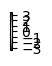

In [32]:
######## New colorbar only for shift + stretch and gaussian ############
x = 3.5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

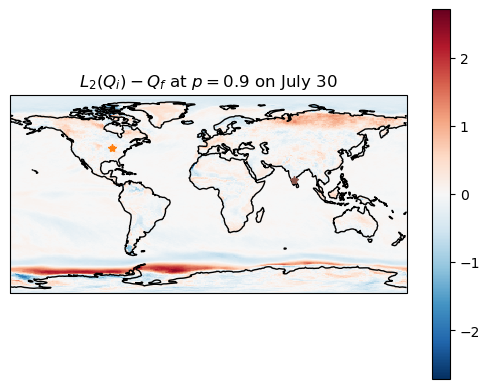

CPU times: user 17.2 s, sys: 789 ms, total: 17.9 s
Wall time: 1min 6s


In [33]:
%%time
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmsc_det_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree())
                                      #,add_colorbar=False)
                                     #cbar_kwargs={'ticks': ticks})
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(r'$L_2(Q_i) - Q_f$ at $p=0.9$ on July 30')
plt.show()

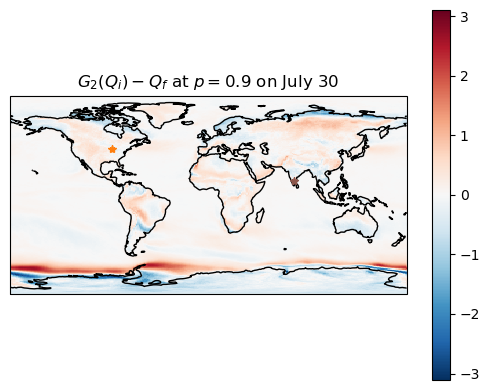

CPU times: user 20 s, sys: 855 ms, total: 20.8 s
Wall time: 1min 21s


In [34]:
%%time
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgauss_det_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree())
                                      #,add_colorbar=False)
                                     #cbar_kwargs={'ticks': ticks})
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(r'$G_2(Q_i) - Q_f$ at $p=0.9$ on July 30')
plt.show()

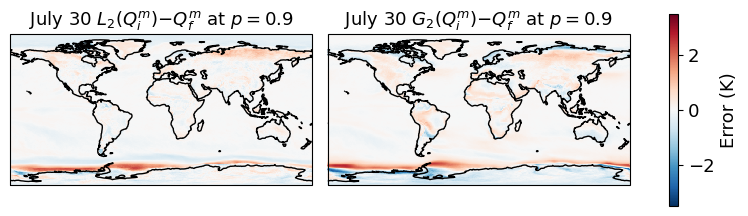

CPU times: user 38.4 s, sys: 1.66 s, total: 40.1 s
Wall time: 2min 46s


In [40]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qgmsc_det_err.sel(quantile=0.9).plot(ax=axs[0], transform=cart.crs.PlateCarree(),add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
#axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_title(r'July 30 $L_2(Q^m_i) − Q^m_f$ at $p = 0.9$',fontsize=13)

# Plotting da2
im = qgauss_det_err.sel(quantile=0.9).plot(ax=axs[1], transform=cart.crs.PlateCarree(), add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
#axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_title(r'July 30 $G_2(Q^m_i) − Q^m_f$ at $p = 0.9$',fontsize=13)

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Error (K)',fontsize=13)
cbar.ax.tick_params(labelsize=13)  

#plt.tight_layout()
plt.show()

### <span style ='color:Red'> This is extra code. Please ignore! </span>

In [1]:
# tgmw_construct_nandrop.sel(lat=LAT,lon=LON,method='nearest').sel(tm=1).values

In [ ]:
# ####### Construct gaussians for model warming ################
# qgauss_mw = xr.apply_ufunc(
#     gauss_quantile,
#     tgmw_mroll0,
#     tgmw_sroll0,
#     quantiles,
#     input_core_dims=[[], [],[]],
#     output_core_dims=[[]],
#     vectorize=True,
#     output_dtypes=[float],
#     #output_sizes={'quantile': 101},
#     dask='parallelized'
# )
# qgauss_mw.name ='TREFHTMX'
# qgauss_mw

In [ ]:
# ####### Construct gaussians for model warming ################
# qg  = xr.apply_ufunc(erfinv, 2*quantiles-1)
# qg

In [ ]:
# qgauss_mw      = tgmw_mroll0 + tgmw_sroll0 * np.sqrt(2) *qg
# qgauss_mw.name = 'TREFHTMX'
# qgauss_mw

In [ ]:
# tgmw_mroll0.sel(lat=LAT,lon=LON,method='nearest').sel(quantile=0.71).plot()

In [ ]:
# # #Add a dummy time dimension to tgnw after relabeling time as 'old_time'
# #tgnw = tgnw.rename({'time':'old_time'})
# tgnw       = tgnw.chunk({'lat':40,'lon':60})
# tgnw_stack = tgnw.stack(mtime=('member','time'),create_index=False)
# tgnw_stack = tgnw_stack.expand_dims(dim={'tm':222}).\
#                assign_coords(tm=('tm',np.arange(1865,2087)))
# tgnw_stack

In [ ]:
# tgmc         = (tgnw_stack - tgnw_stack.mean(dim='mtime'))+tgmw_mroll
# tgmsc        = (tgnw_stack - tgnw_stack.mean(dim='mtime'))*(tgmw_sroll/tgnw_stack.std(dim='mtime'))\
#                 + tgmw_mroll
# tgmc         = tgmc.chunk({'tm':30,'mtime':3000})
# tgmsc        = tgmsc.chunk({'tm':30,'mtime':3000})
# tgnw_stack   = tgnw_stack.chunk({'tm':30,'mtime':3000})

In [ ]:
# %%time
# #Check if the results are reproduced for Bengaluru
# year      = np.arange(1865,2087)
# qmw       = qgmw.sel(lat=LAT,lon=LON,method='nearest')
# qnw       = qgnw.sel(lat=LAT,lon=LON,method='nearest')
# qmc       = qgmc.sel(lat=LAT,lon=LON,method='nearest')
# qmsc      = qgmsc.sel(lat=LAT,lon=LON,method='nearest')
# qgauss    = qgauss_mw.sel(lat=LAT,lon=LON,method='nearest')

# plt.plot(year,qmw.sel(quantile=0.9),'--',color='tab:blue',label='actual')
# plt.plot(year,qmsc.sel(quantile=0.9),color='tab:green',label='pi + shift + stretch')
# plt.plot(year,qgauss.sel(quantile=0.9),color='red',label='gaussian')
# # plt.plot(year,qnw.sel(quantile=0.9),color='tab:blue',label='pi')
# # plt.plot(year,qmc.sel(quantile=0.9),color='tab:orange',label='pi + shift')
# #########
# plt.plot(2086,qmw.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='tab:blue',\
#          markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

# plt.plot(2086,qmsc.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='tab:green',\
#          markeredgecolor='tab:green', lw=2, ms=3, mew=2, color='tab:green')

# plt.plot(2086,qgauss.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='red',\
#          markeredgecolor='red', lw=2, ms=3, mew=2, color='red')

# # plt.plot(2086,qnw.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='tab:blue',\
#          # markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

# # plt.plot(2086,qmc.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='tab:orange',\
#          # markeredgecolor='tab:orange', lw=2, ms=3, mew=2, color='tab:orange')


# plt.legend(loc='upper left')
# plt.title('CESM2: q=0.9,' +locn)
# plt.ylabel(date+': Tmax (K)')
# plt.xlabel('Time')
# #plt.xlim(1864,2087)
# plt.xticks(np.round(np.linspace(1865,2086,8,endpoint=True),0))
# plt.show()

In [ ]:
# %%time
# tgmw_min = tgmw_construct_nandrop.min('index')
# tgmw_max = tgmw_construct_nandrop.max('index')
# tmw_min  = tgmw_min.sel(lat=LAT,lon=LON,method='nearest')
# tmw_max  = tgmw_max.sel(lat=LAT,lon=LON,method='nearest')

In [ ]:
# %%time
# qgmw_diff   =  qgmw.sel(tm=1865) - qgmw.sel(tm=2086) 
# qgmc_diff   =  qgmc.sel(tm=1865) - qgmc.sel(tm=2086)
# qgmsc_diff  =  qgmsc.sel(tm=1865)- qgmsc.sel(tm=2086)
# qgauss_diff =  qgauss_mw.sel(tm=1865) - qgauss_mw.sel(tm=2086)

In [ ]:
# ###### Error in prediction for EOC #######
# qgmsc_err  = qgmsc.sel(tm=2086)     - qgmw.sel(tm=2086)
# qgauss_err = qgauss_mw.sel(tm=2086) - qgmw.sel(tm=2086)

In [ ]:
# qgmw_reldiff1 = qgmw_diff - qgmc_diff
# qgmw_reldiff2 = qgmw_diff - qgmsc_diff
# qgmw_reldiff3 = qgmw_diff - qgauss_diff

In [ ]:
# %%time
# #Understand the ranges of these quantities
# np.min(qgmw_reldiff1.sel(quantile=0.9)).values,np.max(qgmw_reldiff1.sel(quantile=0.9)).values

In [ ]:
#Now, let us compute the relative changes 1) qgmw_diff -0 2) qgmw_diff -qgmc_diff 3) qgmw_diff - qgmsc_diff

In [ ]:
# #Get green, blue, red, and purple colormaps
# green_cmap = cm.get_cmap('Greens')
# blue_cmap = cm.get_cmap('RdBu_r')
# red_cmap = cm.get_cmap('RdBu_r')
# darkred_cmap = cm.get_cmap('spring')


# # Create a list of 42 colors
# colors = []

# # Add 4 decreasing shades of green
# green_range = np.linspace(1, 0.5, 4)
# for i in green_range:
#     colors.append(green_cmap(i))

# # Add 16 decreasing shades of blue from RdBu
# blue_range = np.linspace(0, 0.5, 16)
# for i in blue_range:
#     colors.append(blue_cmap(i))

# # Add white color
# colors.append((1, 1, 1, 1))

# # Add 16 shades of red from RdBu
# red_range = np.linspace(0.5, 1, 16)
# for i in red_range:
#     colors.append(red_cmap(i))

# # Add 6 shades of dark_red
# darkred_range = np.linspace(0.5, 1, 5)
# for i in darkred_range:
#     colors.append(darkred_cmap(i))

In [ ]:
# len(colors)

In [ ]:
# levs     = np.concatenate([altspace(-19.0,3.0,4),\
#                            altspace(-4.0,0.25,32),altspace(4,3,6)])
# levs

In [ ]:
# bu_color = mcolors.to_rgb('b')
# rd_color = mcolors.to_rgb('r')
# print(bu_color)
# ################################
# norm = mcolors.Normalize(-19,19)
# # colors = [[norm(-19.0), "#76d154"],
# #           [norm(-6.0), '#1fa187'],
# #           [norm(-4.0),'royalblue'],
# #           [norm( 0), "white"],
# #           [norm( 4.0), rd_color],
# #           [norm(19.0), 'purple']]
# ####################
# colors0  = list(zip(norm(levs),colors))

# cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors0)
# cmap

In [ ]:
#qgmw_diff.sel(quantile=0.9).sel(lat=chic_lat,lon=chic_lon,method='nearest')

In [ ]:
# ticks    = np.concatenate([altspace(-19.0,3.0,6), altspace(-2.0,2,3),altspace(4,3,6)])
# ticks

In [ ]:
# ######## New colorbar only for shift + stretch and gaussian ############
# x = 3.5
# # create a figure and axis
# fig, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)
# # Define colormap
# cmap = plt.get_cmap('RdBu_r')
# # Make a norm object with the center at 0: TwoSlopeNorm
# norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# # Making numpy array from -3 to 3, with step 0.2
# values = np.arange(-x, x+0.25, 0.25)
# # Creating a mappable object and setting the norm and cmap for colorbar
# mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
# mappable.set_array([])
# # Creating a colorbar
# ticks1 = altspace(-4,1,9)
# cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
# cbar.set_label('')
# plt.gca().set_visible(False)

In [ ]:
# %%time
# #PLot 3c
# levels        = np.arange(-3.25,3.75,0.25)
# ax            = plt.axes(projection=cart.crs.PlateCarree())
# qgmsc_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap=cmap,norm=norm)
#                                       #,add_colorbar=False)
#                                      #cbar_kwargs={'ticks': ticks})
# ax.coastlines(color="black")
# #plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
# plt.plot(-87.629,41.94,marker='*',color='tab:orange')
# plt.plot(77.5,12.72,marker='*',color='tab:brown')
# plt.xlabel('lon')
# plt.ylabel('lat')
# plt.title('(pi + shift + stretch) - actual')
# #plt.title('')
# plt.show()

In [ ]:
# %%time
# #PLot 3d
# ax            = plt.axes(projection=cart.crs.PlateCarree())
# qgauss_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap=cmap,norm=norm)
#                                      #add_colorbar=False)
#                                      #cbar_kwargs={'ticks': ticks})
# ax.coastlines(color="black")
# #plt.title('q=0.9,'+r'$\delta t_w - \delta t_{gauss}$')
# plt.plot(-87.629,41.94,marker='*',color='tab:orange')
# plt.plot(77.5,12.72,marker='*',color='tab:brown')
# plt.xlabel('lon')
# plt.ylabel('lat')
# plt.title('gauss - actual')
# #plt.title('')
# plt.show()

In [ ]:
# %%time
# # Creating a figure and axes
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
#                        , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# # Plotting qgmsc_err
# qgmsc_err.sel(quantile=0.9).plot(ax=axs[0], transform=cart.crs.PlateCarree(),add_colorbar=False, cmap=cmap, norm=norm)
# axs[0].coastlines(color="black")
# #axs[0].add_feature(cfeature.BORDERS, linestyle=':')
# axs[0].set_title('(pi + shift + stretch) - eoc')

# # Plotting da2
# im = qgauss_err.sel(quantile=0.9).plot(ax=axs[1], transform=cart.crs.PlateCarree(), add_colorbar=False, cmap=cmap, norm=norm)
# axs[1].coastlines(color="black")
# #axs[1].add_feature(cfeature.BORDERS, linestyle=':')
# axs[1].set_title('gauss - eoc')

# # Adding colorbar
# cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
# cbar.set_label('Errors (K)')

# #plt.tight_layout()
# plt.show()

### <span style ='color:Red'> This is extra code. Please ignore! </span>

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': cart.crs.PlateCarree()})

# data_arrays = [qgmw_diff.sel(quantile=0.9), qgmw_reldiff1.sel(quantile=0.9), qgmw_reldiff2.sel(quantile=0.9)]
# titles = [' pi - actual', ' (pi + shift) - actual', '(pi + shift + stretch) - actual']
# locations = [(-87.629, 41.94, 'tab:orange'), (77.5, 12.72, 'tab:brown')]

# for ax, data, title in zip(axes, data_arrays, titles):
#     img = data.plot(ax=ax, transform=cart.crs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
#     for loc in locations:
#         ax.plot(loc[0], loc[1], marker='*', color=loc[2])
#     ax.set_xlabel('lon')
#     ax.set_ylabel('lat')
#     ax.coastlines(color="black")
#     ax.set_title(title)

# # Add a single colorbar
# fig.subplots_adjust(right=0.8,wspace=0.1)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# fig.colorbar(img, cax=cbar_ax, ticks=ticks)
# # Add a title to the whole plot
# fig.suptitle("July 30 Tmax, q=0.9", fontsize=15)

# plt.show()

In [ ]:
############# Compute area-weighted mean square of the above errors #####################

In [ ]:
# qgmw_error_square  = qgmw_diff**2
# qgmc_error_square  = qgmw_reldiff1**2
# qgmsc_error_square = qgmw_reldiff2**2

In [ ]:
# weights      = np.cos(np.deg2rad(qgmw_error_square.lat))
# weights.name = "weights"
# #weights

In [ ]:
# qgmw_serror_weighted  = qgmw_error_square.weighted(weights)
# qgmc_serror_weighted  = qgmc_error_square.weighted(weights)
# qgmsc_serror_weighted = qgmsc_error_square.weighted(weights)
# qgmc_serror_weighted

In [ ]:
# %%time
# qgmw_serror_gmean   = qgmw_serror_weighted.mean({'lat','lon'})
# qgmc_serror_gmean   = qgmc_serror_weighted.mean({'lat','lon'})
# qgmsc_serror_gmean  = qgmsc_serror_weighted.mean({'lat','lon'})
# qgmc_serror_gmean

In [ ]:
# %%time
# #p= percentile
# qgmw_gmeanpath  = cvals+'qgmw_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
# qgmc_gmeanpath  = cvals+'qgmc_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
# qgmsc_gmeanpath = cvals+'qgmsc_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
# # qgmw_serror_gmean.to_dataset().to_zarr(qgmw_gmeanpath,mode='w')
# # qgmc_serror_gmean.to_dataset().to_zarr(qgmc_gmeanpath,mode='w')
# # qgmsc_serror_gmean.to_dataset().to_zarr(qgmsc_gmeanpath,mode='w')

In [ ]:
# qgmc_serror_gmean.values

In [ ]:
# %%time
# qgmw_serror_gmean  = xr.open_zarr(qgmw_gmeanpath)
# qgmc_serror_gmean  = xr.open_zarr(qgmc_gmeanpath)
# qgmsc_serror_gmean = xr.open_zarr(qgmsc_gmeanpath)
# qgmw_serror_gmean  = qgmw_serror_gmean.TREFHTMX
# qgmc_serror_gmean  = qgmc_serror_gmean.TREFHTMX
# qgmsc_serror_gmean = qgmsc_serror_gmean.TREFHTMX
# qgmw_grmse         = np.sqrt(qgmw_serror_gmean)
# qgmc_grmse         = np.sqrt(qgmc_serror_gmean)
# qgmsc_grmse        = np.sqrt(qgmsc_serror_gmean)

In [ ]:
# %%time
# #plt.plot(quants,qgmw_serror_gmean,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
# plt.plot(quants,qgmc_grmse,label='pi+ 30-yr rolling mean',c='orange')
# plt.plot(quants,qgmsc_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
# plt.legend(loc='upper left')
# plt.title('CESM2: Global RMSEs')
# plt.ylabel(date+'-Tmax (K)')
# plt.xlabel('Percentiles')
# # plt.xlim([0, max(x)+1])
# # plt.ylim([0, max(y)+1])
# plt.show()

In [ ]:
# %%time
# plt.plot(quants,qgmw_grmse,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
# plt.plot(quants,qgmc_grmse,label='pi+ 30-yr rolling mean',c='orange')
# plt.plot(quants,qgmsc_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
# plt.legend(loc='upper left')
# plt.title('CESM2: Global RMSEs')
# plt.ylabel(date+'-Tmax (K)')
# plt.xlabel('Percentiles')
# plt.xlim([0.0, np.max(quants)+.01])
# #plt.ylim([0.0, np.max(y)+1])
# plt.show()